In [196]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
import os

import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scipy.stats import skew, kurtosis
import pandas as pd

In [4]:
path = 'E:\EpochedEEG'
epoch_files = os.listdir(path)

In [5]:
file = os.path.join(path,epoch_files[0])

In [6]:
epoch = mne.read_epochs(file, preload = True)

Reading E:\EpochedEEG\20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [7]:
pca = UnsupervisedSpatialFilter(PCA(28), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
pca_data = pca.fit_transform(epoch_data)

In [8]:
gamma_epoch = epoch.filter(l_freq=30, h_freq= 100)
beta_epoch =  epoch.filter(l_freq=12, h_freq= 30)
alpha_epoch = epoch.filter(l_freq=8, h_freq= 12)
theta_epoch = epoch.filter(l_freq=4, h_freq= 7)
delta_epoch = epoch.filter(l_freq=0, h_freq= 4)

Setting up band-pass filter from 30 - 1e+02 Hz
l_trans_bandwidth chosen to be 7.5 Hz
h_trans_bandwidth chosen to be 25.0 Hz
Filter length of 113 samples (0.441 sec) selected
Setting up band-pass filter from 12 - 30 Hz
l_trans_bandwidth chosen to be 3.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 283 samples (1.105 sec) selected
filter_length (283) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-8-d74bec87c4a9>:2: RuntimeWarning: filter_length (283) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.
  beta_epoch =  epoch.filter(l_freq=12, h_freq= 30)


Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 423 samples (1.652 sec) selected
filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-8-d74bec87c4a9>:3: RuntimeWarning: filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.
  alpha_epoch = epoch.filter(l_freq=8, h_freq= 12)


Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 423 samples (1.652 sec) selected
filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-8-d74bec87c4a9>:4: RuntimeWarning: filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.
  theta_epoch = epoch.filter(l_freq=4, h_freq= 7)


Setting up low-pass filter at 4 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 423 samples (1.652 sec) selected
filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.


<ipython-input-8-d74bec87c4a9>:5: RuntimeWarning: filter_length (423) is longer than the signal (180), distortion is likely. Reduce filter length or filter a longer signal.
  delta_epoch = epoch.filter(l_freq=0, h_freq= 4)


In [85]:
gamma_data = gamma_epoch.get_data()
beta_data = beta_epoch.get_data()
alpha_data = alpha_epoch.get_data()
theta_data = theta_epoch.get_data()
delta_epoch = delta_epoch.get_data()

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

In [86]:
gamma_pca_data = pca.fit_transform(gamma_data)
beta_pca_data = pca.fit_transform(beta_data)
alpha_pca_data = pca.fit_transform(alpha_data)
theta_pca_data = pca.fit_transform(theta_data)
delta_pca_data = pca.fit_transform(delta_epoch)# didn't name this correctly

## average data from each band

In [87]:
gamma_pca_data.shape

(5424, 28, 180)

In [88]:
# final_data = np.shape()
final_means = []
for data in gamma_pca_data:
#     print (data.shape)
    means = []
    for channel in data:
#         print(channel.shape)
        mean = channel.mean()
        means.append(mean)
    final_means.append(means)
final_means = np.array(final_means)

In [89]:
final_means.shape

(5424, 28)

In [220]:
def get_mean_band(data):
    final_variances = []
    for d in data:
    #     print (data.shape)
        variances = []
        skewnesses = []
        kurtosises = []
        stats = []
        for channel in d:
    #         print(channel.shape)
            var = channel.var()
            variances.append(var)
            
            skewness = skew(channel, axis=0)
#             print(skewness)

            skewnesses.append(skewness)
#             print(skewness)
            kurt = kurtosis(channel)
            kurtosises.append(kurt)
#         print(skewnesses)
#         mean_skew = np.mean(skewnesses)
#         stats.append(mean_skew)
#         stats.append(np.mean(variances))
        final_variances.append([np.mean(variances), np.mean(skewnesses), np.mean(kurtosises)])
    
    return np.array(final_variances)

In [221]:
gamma_final_mean = get_mean_band(gamma_pca_data)
beta_final_mean = get_mean_band(beta_pca_data)
alpha_final_mean = get_mean_band(alpha_pca_data)
delta_final_mean = get_mean_band(delta_pca_data)
theta_final_mean = get_mean_band(theta_pca_data)
regular_data_final_mean = get_mean_band(pca_data)                                 

In [137]:
delta_final_mean.shape

(5424,)

In [222]:
results = np.concatenate((gamma_final_mean,
                          beta_final_mean,
                          alpha_final_mean,
                          delta_final_mean,
                          theta_final_mean,
                          regular_data_final_mean),axis = 1)

In [224]:
results.shape

(5424, 18)

## plotting frequency bands

In [142]:
gamma_final_mean.shape

(5424,)

In [145]:
results[:10,2]

array([3.38604387e+00, 9.39360119e+00, 9.39360119e+00, 9.39360119e+00,
       9.39309524e+00, 1.77579365e-03, 9.66820988e-03, 1.02001587e+01,
       1.02001587e+01, 1.02001587e+01])

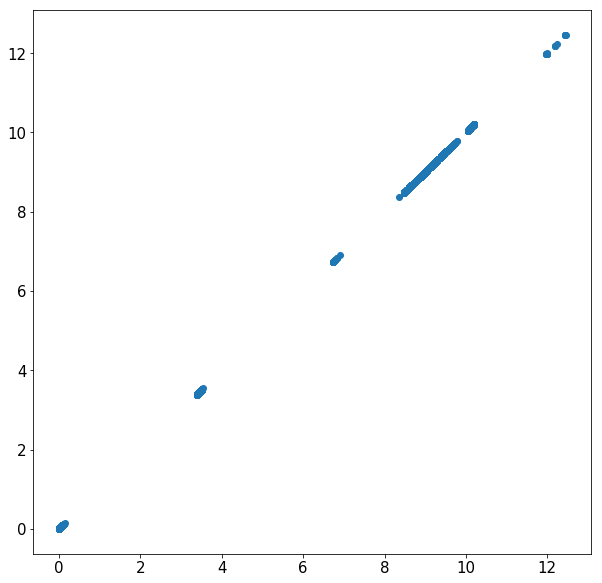

In [146]:
plt.scatter(data[], results[:,3]);

## extract congruent & incongruent labels

In [147]:
events = epoch.events[:,-1]

(array([1015.,    0.,  313.,    0.,    0.,  250.,  341., 2204., 1282.,
          19.]),
 array([1.97310436e-04, 1.24532694e+00, 2.49045657e+00, 3.73558620e+00,
        4.98071583e+00, 6.22584546e+00, 7.47097509e+00, 8.71610472e+00,
        9.96123435e+00, 1.12063640e+01, 1.24514936e+01]),
 <a list of 10 Patch objects>)

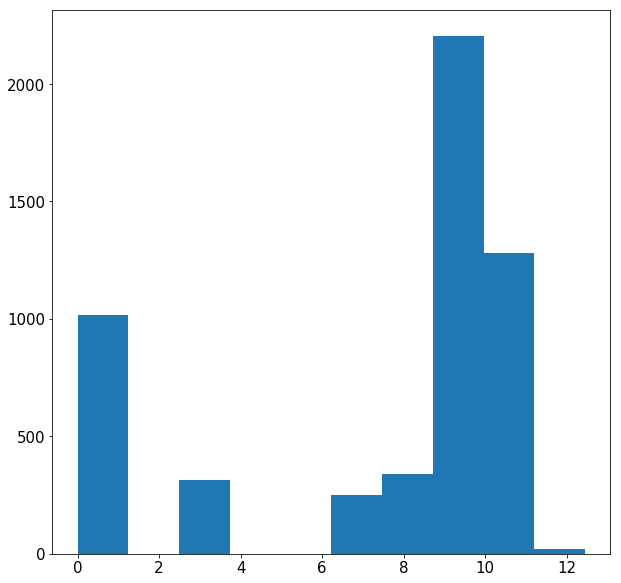

In [175]:
plt.

In [225]:
event_ids = epoch.event_id

In [226]:
labels = [x for x in events if x == 133 or x == 134]

In [227]:
# labels

In [229]:
df = pd.DataFrame(data = results)
df['labels'] = events
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,labels
0,3.386044,0.488472,6.806278,3.386044,0.486839,6.812505,3.386044,0.490505,6.806856,3.386044,0.494164,6.808174,3.386044,0.541587,6.809818,3.386044,0.689859,7.630383,131
1,9.393601,0.234367,4.122465,9.393601,0.227754,4.108319,9.393601,0.234367,4.130163,9.393601,0.233151,4.136674,9.393601,0.353169,4.117032,9.393601,0.361434,3.604639,31
2,9.393601,0.211692,5.504006,9.393601,0.210431,5.506521,9.393601,0.217669,5.520877,9.393601,0.214994,5.512341,9.393601,0.281951,5.513245,9.393601,0.355719,3.606906,144
3,9.393601,0.400234,4.241906,9.393601,0.401166,4.243094,9.393601,0.392107,4.245564,9.393601,0.391720,4.250504,9.393601,0.315885,4.241021,9.393601,0.295052,3.044671,162
4,9.393095,0.134880,4.074491,9.393095,0.131267,4.081047,9.393095,0.131694,4.079205,9.393095,0.131495,4.081700,9.393095,0.167721,4.095498,9.393095,0.274034,2.968560,8


In [235]:
# get the labels of congruent and incongruent
data = df[(df['labels'] == 133) | (df['labels'] == 134)]
data = data.reset_index()
X = data.values[:,:6]
y = data.values[:,-1:]

In [236]:
normed_X = normalize(X)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(normed_X,y, test_size = 0.3, random_state = 42)

In [238]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [239]:
knn.score(X_test, y_test)

0.4791666666666667

In [241]:
X.shape

(640, 6)

In [242]:
plt.scatter(X[y == 133,0], X[y == 134,0])

IndexError: too many indices for array

In [189]:
clf = LogisticRegression()
clf.fit(X_train, y_train.ravel())
clf.score(X_test,y_test)

0.4479166666666667

In [63]:
gamma_final_mean.shape

(5424, 1)

In [31]:
# concat_array.shape

NameError: name 'concat_array' is not defined

In [ ]:
# concat_array

In [32]:
gamma_final_mean_3d = gamma_final_mean[:,np.newaxis,:]
gamma_final_mean_3d.shape

(5424, 1, 28)

In [33]:
gamma_final_mean_3d = gamma_final_mean[...,np.newaxis]
beta_final_mean_3d = beta_final_mean[...,np.newaxis]
alpha_final_mean_3d = alpha_final_mean[...,np.newaxis]
delta_final_mean_3d = delta_final_mean[...,np.newaxis]
theta_final_mean_3d = theta_final_mean[...,np.newaxis]
regular_final_mean_3d = regular_data_final_mean[...,np.newaxis]

In [34]:
results = np.concatenate((gamma_final_mean_3d,
                          beta_final_mean_3d,
                          alpha_final_mean_3d,
                          delta_final_mean_3d,
                          theta_final_mean_3d,
                          regular_final_mean_3d), axis = 2)

In [35]:
results.shape

(5424, 28, 6)

In [84]:
results.shape

(5424, 112)

In [83]:
results

array([[9.48092284e+01, 2.54036733e-14, 3.98203333e-16, ...,
        5.06747997e-17, 2.91709662e-16, 1.99728688e-16],
       [2.63020833e+02, 6.85103270e-14, 8.56307043e-15, ...,
        1.12817652e-16, 5.20600004e-16, 5.65786132e-16],
       [2.63020833e+02, 3.43498574e-14, 1.29864221e-14, ...,
        8.44040557e-16, 2.11576834e-16, 2.31019793e-16],
       ...,
       [9.48066667e+01, 1.15964729e-15, 1.36319176e-15, ...,
        3.30276350e-16, 1.27914633e-16, 4.97302674e-16],
       [2.82734414e+02, 1.52442230e-15, 6.39534077e-15, ...,
        1.88031892e-16, 1.12768466e-16, 1.47516428e-16],
       [1.90070710e+02, 7.74529787e-15, 6.84704476e-15, ...,
        2.51718968e-16, 1.22704620e-16, 1.45636172e-16]])